<a href="https://colab.research.google.com/github/furahadamien/fradaX/blob/master/mlpCIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration: 0  --  Loss: 59.89206769319145
Iteration: 1000  --  Loss: 1.8760800311071375
Iteration: 2000  --  Loss: 1.6616227678363473
Iteration: 3000  --  Loss: 1.4756179573387445
Iteration: 4000  --  Loss: 1.2992323948636395
Iteration: 5000  --  Loss: 1.1323009730963534
Iteration: 6000  --  Loss: 0.9774492605200058
Iteration: 7000  --  Loss: 0.8577470592360125
Iteration: 8000  --  Loss: 0.719147745026479
Iteration: 9000  --  Loss: 0.639167148052773
Iteration: 10000  --  Loss: 0.5588514512856371
Iteration: 11000  --  Loss: 0.49918294397864643
Iteration: 12000  --  Loss: 0.43279083392808854
Iteration: 13000  --  Loss: 0.36466884778012015
Iteration: 14000  --  Loss: 0.29890183344067417
Iteration: 15000  --  Loss: 0.38350652851128053
Iteration: 16000  --  Loss: 0.2441613692665127
Iteration: 17000  --  Loss: 0.22552452320168803
Iteration: 18000  --  Loss: 0.19609644399857398
Iteration: 19000  --  Loss: 0.1718400858576789
Iteration: 20000  --  Loss: 0.15198691851627594
Iteration: 21000  -- 

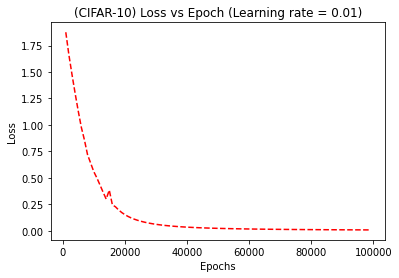

In [11]:
import pickle as pickle
import numpy as np
import pandas as pd
import os
import math
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
import scipy.sparse
import copy
import random
import matplotlib 
import matplotlib.pyplot as plt

def load_data(dir, train_set=49000, validation_set=1000, test_set=1000):
    X_train, y_train, X_test, y_test = load(dir) #loading data

    # Subsample the data
    mask = range(train_set, train_set + validation_set)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(train_set)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(test_set)
    X_test = X_test[mask]
    y_test = y_test[mask]

    X_train = X_train.astype(np.float64)
    X_val = X_val.astype(np.float64)
    X_test = X_test.astype(np.float64)

    """
    we tanspose the samples so that the channels come first
    """
    X_train = X_train.transpose(0, 3, 1, 2)
    X_val = X_val.transpose(0, 3, 1, 2)
    X_test = X_test.transpose(0, 3, 1, 2)
    image = np.mean(X_train, axis=0)
    std_dev = np.std(X_train)

    X_train -= image
    X_val -= image
    X_test -= image

    X_train /= std_dev
    X_val /= std_dev
    X_test /= std_dev
    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'mean': image, 'std': std_dev
    }

"""
Load bacthes of the data downloaded from https://www.cs.toronto.edu/~kriz/cifar.html
image data is already split into batches that we use for our experiment
"""
def get_batches(filename):
    with open(filename, 'rb') as f:
        images = pickle.load(f, encoding ='bytes') # encoding into byte data
        X = images[b'data']
        Y = images[b'labels']
        #reshape the image array
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)
        Y = np.array(Y)
        return X, Y

#gets data from from the root directory.
#full CIFAR-10 data set should be downloaded into the project root directory
def get_data(root_dir):
    xs = []
    ys = []
    for b in range(1, 6):
        #data is already split into training and testing batches
        f = os.path.join(root_dir, 'data_batch_%d' % (b, ))
        X, Y = get_batches(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    
    #get testing batch
    Xte, Yte = get_batches(os.path.join(root_dir, 'test_batch'))
    return Xtr, Xte, Ytr, Yte

def load(file_name):
        train_x, test_x, train_y, test_y = get_data("")
        # covert N x 3 x 32 x 32 to N x 3072
        train_x = np.reshape(train_x, (len(train_x), 3 * 32 * 32))
        test_x = np.reshape(test_x, (len(test_x), 3 * 32 * 32))
        
        return train_x, test_x, train_y, test_y

##Cost finctions used in the experiment
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_prime(z):
    return z * (1 - z)

def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z), axis=1)).T
    return sm

def softmax_prime(z):
    return

def relu(z):
    return np.maximum(z, 0)

def relu_prime(z):
    dz = np.ones_like(z)
    dz[z < 0] = 0
    return dz

#weight initialization methods
def relu_weight(m, n):
    np.random.seed(0)
    return np.random.rand(m, n) * np.sqrt(2) / np.sqrt(m)

def xavier(m, n):
    np.random.seed(0)
    return np.random.rand(m, n) / np.sqrt(m)

def he(m, n):
    np.random.seed(0)
    return np.random.rand(m, n) * np.sqrt(2) / np.sqrt(m + n)

class Layers(object):

    def __init__(self, n_in, n_out=10, activation_function="relu"):
        self.n_in = n_in
        self.n_out = n_out
        self.set_activation_functions(act_function_name=activation_function)

    def set_activation_functions(self, act_function_name="relu"):
        if act_function_name == "relu":
            self.activation_function = relu
            self.function = relu_prime
            self.set_weight_function(init_function="he")
        elif act_function_name == "sigmoid":
            self.activation_function = sigmoid
            self.function = sigmoid_prime
            self.set_weight_function(init_function="xavier")
        elif act_function_name == "softmax":
            self.activation_function = softmax
            self.function = softmax_prime
            self.set_weight_function(init_function="he")

    #weight initialization. 
    def set_weight_function(self, init_function):
        if init_function == "relu":
            self.weight_function = relu_weight
        elif init_function == "xavier":
            self.weight_function = xavier
        elif init_function == "he":
            self.weight_function = he

class Multi_Layer(object):
    
    def __init__(self, n_in=784, n_out=10, l_rate=0.01):

        self.n_in = n_in
        self.n_out = n_out
        self.initial_lrate = l_rate
        self.l_rate = l_rate

        self.weights = []
        self.biases = []
        self.previous_weights = []
        self.previous_biases = []
        self.layers = []
        self.losses = []
        
        

    def layer(self, activation_function="relu", num_perceptrons=4):
        if len(self.layers) <= 0:
            perceptrons = self.n_in
        else:
            perceptrons = self.layers[-1].n_out

        L = Layers(n_in=perceptrons, n_out=num_perceptrons, activation_function=activation_function)
        self.layers.append(L)
        
    
    def backprop_weights(self):
        self.previous_weights.append(self.weights)
        self.previous_biases.append(self.biases)
    
    
    def forward(self, X):
        a = [X]
        for l in range(len(self.layers)):
            z = a[l].dot(self.weights[l]) + self.biases[l]
            activation = self.layers[l].activation_function(z)
            a.append(activation)

        return a
    
    """
    Backpropagation method. Computes the gradient through previous layers and it trains
    uses the compuatation to update the weights of the non-linearity
    """
    def backpropagation(self, x,y_mat,a):
        m = x.shape[0]
        output = a[-1]
        
        #Computes loss
        loss = (-1 / m) * np.sum(y_mat * np.log(output))
        deltas = []
        delta = y_mat - output
        deltas.append(delta)
        
        for l in range(len(self.layers)-1):
            prime = self.layers[-2 - l].function(a[-2 - l])
            w = self.weights[-1-l]
            delta = np.dot(delta, w.T) * prime
            deltas.append(delta)
        
        prev_weights = self.previous_weights.pop(0)
        prev_biases = self.previous_biases.pop(0)

        #Stochastic Gradient Descent part
        #loss gradients w.r.t input
        for l in range(len(self.layers)-1):
            dw = (2/m) * np.dot(a[l].T,deltas[-1-l])
            self.weights[l] += self.l_rate * dw
            
            db = (1/m) * np.sum(deltas[-1-l], axis=0, keepdims=True)
            self.biases[l] += self.l_rate * db
   
        self.backprop_weights()
        return loss
    
    #initialize weights of the non-linearity
    # We use Xavier initilaization(above) in our experiment
    def weight_init(self):
        for i in range(len(self.layers)):
            curr_layer = self.layers[i].n_out
            prev_layer = self.layers[i].n_in
            weights = self.layers[i].weight_function(prev_layer, curr_layer)
            self.weights.append(weights)
            biases = np.zeros((1, curr_layer))
            self.biases.append(biases)

    #Training the netork
    def train(self, x, y, iteration=100000):
        
        self.weight_init()
        self.backprop_weights()
        
        y_mat = self.one_hot_encoding(y)
        for i in range(iteration):
            a = self.forward(x)
            loss = self.backpropagation(x,y_mat,a)
                       
            if i%1000==0:
                print('Iteration: {0}  --  Loss: {1}'.format(i,loss))
                self.losses.append([i,loss])
             

    # we perform one hot encoding pre-processing step
    def one_hot_encoding(self, Y):
        labels = Y.shape[0]
        label = scipy.sparse.csr_matrix((np.ones(labels), (Y, np.array(range(labels)))))
        label = np.array(label.todense()).T
        return label
    
    def val_predicted(self, x):
        probability = self.forward(x)[-1]
        preds = np.argmax(probability,axis=1)      
        return probability,preds

    def get_accuracy(self, x,y):
        prob,predicted_val = self.val_predicted(x)
        accuracy = sum(predicted_val == y)/(float(len(y)))
        percentage = accuracy*100
        return percentage
    
    def plot_loss(self):
        errors = np.array(self.losses)
        plt.plot(errors[1:, 0], errors[1:, 1], 'r--')
        plt.title("(CIFAR-10) Loss vs Epoch (Learning rate = 0.01)")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()



#GET CIFAR-DATA
train_x, test_x, train_y, test_y = load(file_name="cifar")

#data normalization
X_train = train_x[:1000] / 255.
y_train = train_y[:1000].astype(int)
X_test = test_x[:100] / 255.
y_test = test_y[:100].astype(int)

n_in = X_train.shape[1]

mlp = Multi_Layer(n_in=n_in, n_out=10)

"""
for all hidden layers, either ReLU or sigmoid activation functions are used
and their eventual perfomance compared
for output layer, Softmax is used
"""
List = ["relu", "sigmoid"]
activation_func = random.choice(List)
mlp.layer(activation_func, num_perceptrons=80)
mlp.layer(activation_func, num_perceptrons=30)
mlp.layer(activation_function="softmax", num_perceptrons=10)

mlp.train(X_train, y_train, iteration=100000)

train_accuracy = mlp.get_accuracy(X_train,y_train)
test_accuracy = mlp.get_accuracy(X_test,y_test)


print('Training Accuracy: {0:0.2f} %'.format(train_accuracy))
print('Test Accuracy: {0:0.2f} %'.format(test_accuracy))

mlp.plot_loss()
